In [6]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [7]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 데이터 적재와 분할
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

scaler = MinMaxScaler().fit(X_train)   # train set 기준으로 스케일 조정

# train data scale
X_train_scaled = scaler.transform(X_train)

svm = SVC()

# 스케일 조정된 훈련 데이터에 SVM 학습
svm.fit(X_train_scaled, y_train)

# 테스트 데이터의 스케일 조정 후 점수 계산
X_test_scaled = scaler.transform(X_test)

print('test score: {:.3f}'.format(svm.score(X_test_scaled, y_test)))

test score: 0.951


In [4]:
cancer.feature_names

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

In [9]:
# 데이터 전처리와 매개변수 선택

from sklearn.model_selection import GridSearchCV
# 예를 위한 코드. 실사용x
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
grid.fit(X_train_scaled, y_train)
print('최상 교차검증  acc: {:.2f}'.format(grid.best_score_))
print('test score: {:.2f}'.format(grid.score(X_test_scaled, y_test)))
print('최적 매개변수:', grid.best_params_)

최상 교차검증  acc: 0.98
test score: 0.97
최적 매개변수: {'C': 1, 'gamma': 1}


In [10]:
# 함점: scale 때 train set 전체를 사용(val set에 들어있는 정보도 이미 사용) -> 낙관적인 결과.
# =>해결: 교차 검증의 분할이 모든 전처리 과정보다 앞서 이뤄져야 한다.

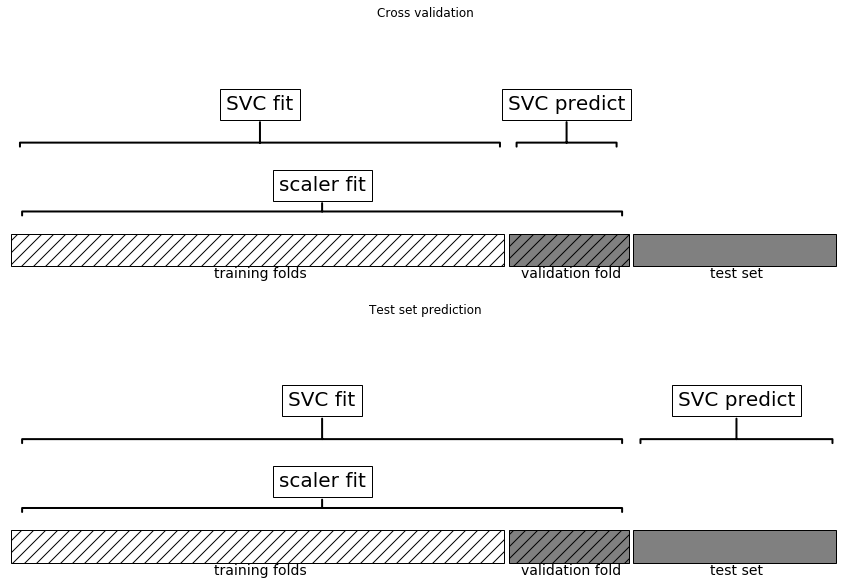

In [8]:
import mglearn
mglearn.plots.plot_improper_processing()

#### Pipeline 구축

In [9]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([('scaler', MinMaxScaler()), ('svm', SVC())])

In [10]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('svm',
                 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3,
                     gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [11]:
print('test score: {:.2f}'.format(pipe.score(X_test, y_test)))

test score: 0.95


In [17]:
from sklearn.model_selection import GridSearchCV

In [18]:
# 그리드 서치에 파이프라인 적용

param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}    # 파이프라인용 매개변수 그리드는 단계 이름과 매개변수 이름을 __로 연결

grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print('최상 교차검증  acc: {:.2f}'.format(grid.best_score_))
print('test score: {:.2f}'.format(grid.score(X_test, y_test)))
print('최적 매개변수:', grid.best_params_)

최상 교차검증  acc: 0.98
test score: 0.97
최적 매개변수: {'svm__C': 1, 'svm__gamma': 1}


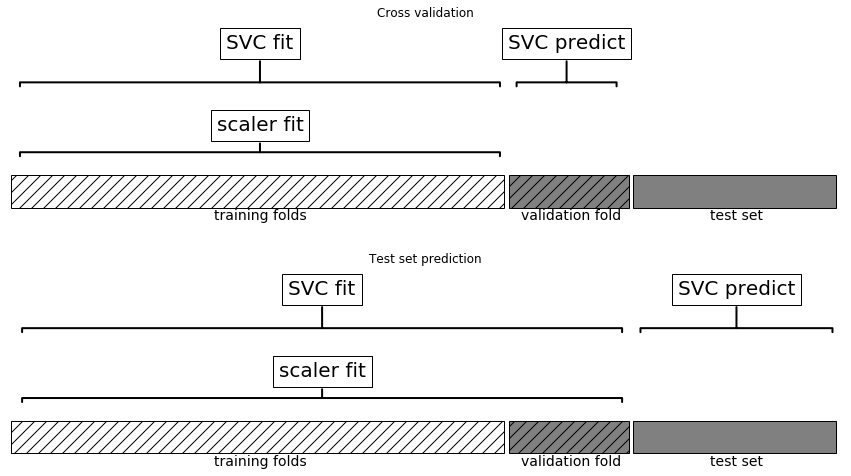

In [19]:
mglearn.plots.plot_proper_processing()

#### 정보 누설에 대한 예시

In [20]:
import numpy as np

rnd = np.random.RandomState(seed=0)
X = rnd.normal(size=(100, 10000))    # 정규분포로부터 독립적으로 추출한 10000개의 특성을 가진 샘플 100개
y = rnd.normal(size=(100,))

In [21]:
# 무작위로 생성했기 때문에, X와 y 사이에 아무런 관계 없음. (독립적) 학습 불가능.
# -> 10000개 중 가장 유용한 특성 선택 후 교차 검증해 Ridge 회귀 평가

In [22]:
from sklearn.feature_selection import SelectPercentile, f_regression

select = SelectPercentile(score_func=f_regression, percentile=5).fit(X, y)
X_selected = select.transform(X)
print('X_selected.shape:', X_selected.shape)

X_selected.shape: (100, 500)


In [23]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
print("교차 검증 점수 (Ridge): {:.2f}".format(np.mean(cross_val_score(Ridge(), X_selected, y, cv=5))))

교차 검증 점수 (Ridge): 0.91


In [24]:
# 무작위로 만든 모델을 훈련했는데 R^2 score가 0.91? 불가능한 일.

In [25]:
pipe = Pipeline([('select', SelectPercentile(score_func=f_regression, percentile=5)),
                 ('ridge', Ridge())])
print('교차 검증 점수 (pipeline): {:.2f}'.format(np.mean(cross_val_score(pipe, X, y, cv=5))))

교차 검증 점수 (pipeline): -0.25


In [26]:
# 파이프라인 사용: 특성 선택이 교차 검증 반복 안으로 들어감. 즉 테스트 폴드는 전혀 사용하지 않고 특성 선택 진행했음.
# 특성 선택 단계에서 일어나는 정보 누설을 막는 것이 모델 성능 평가하는 데 큰 차이 만든다.

### 6.3 파이프라인 인터페이스

- Pipeline은 전처리나 분류에 국한x 어떤 추정기와도 연결 가능.
- 특성 추출, 특성 선택, 스케일 변경, 분류(혹은 회귀나 군집) 총 네 단계 파이프라인 등.
- 마지막 단계를 제외하고는 모두 transform 메서드를 가지고 있어야 함. 이전 단계의 transform의 출력을 입력으로 받아 fit, transform 호출.
- 마지막 단계는 fit 메서드만 호출.

In [26]:
def fit(self, X, y):
    X_transformed = X
    for name, estimator in self.steps[:-1]:
        # 마지막 단계를 빼고 fit과 transform을 반복
        X_transformed = estimator.fit_transform(X_transformed, y)
    # 마지막 단계 fit을 호출
    self.steps[-1][1].fit(X_transformed, y)
    return self

In [27]:
def predict(self, X):
    X_transformed = X
    for step in self.steps[:-1]:
        # 마지막 단계를 빼고 transform을 반복
        X_transformed = step[1].transform(X_transformed)
    # 마지막 단계 predict를 호출
    return self.steps[-1][1].predict(X_transformed)

### 6.4.1. make_pipeline을 사용한 파이프라인 생성

In [29]:
from sklearn.pipeline import make_pipeline

# 표준적인 방법
pipe_long = Pipeline([('scaler', MinMaxScaler()), ('svm', SVC(C=100))])

# 간소화된 방법
pipe_short = make_pipeline(MinMaxScaler(), SVC(C=100))

In [32]:
print('long 파이프라인 단계:\n', pipe_long.steps)

long 파이프라인 단계:
 [('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svm', SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False))]


In [33]:
print('short long 파이프라인 단계:\n', pipe_short.steps)

short long 파이프라인 단계:
 [('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svc', SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False))]


In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe = make_pipeline(StandardScaler(), PCA(n_components=2), StandardScaler())
print('파이프라인 단계:\n', pipe.steps)

파이프라인 단계:
 [('standardscaler-1', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)), ('standardscaler-2', StandardScaler(copy=True, with_mean=True, with_std=True))]


In [35]:
pipe.fit(cancer.data)
components = pipe.named_steps['pca'].components_
print(components.shape)

(2, 30)


### 6.4.3.그리드 서치 안의 파이프라인 속성에 접근하기

In [36]:
from sklearn.linear_model import LogisticRegression
pipe = make_pipeline(StandardScaler(), LogisticRegression())

In [37]:
param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10, 100]}

In [38]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=4)
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('logisticregression',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
                                                     

In [39]:
grid.best_estimator_

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=0.1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='warn', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [40]:
grid.best_estimator_.named_steps['logisticregression']

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [42]:
grid.best_estimator_.named_steps['logisticregression'].coef_

array([[-0.38856355, -0.37529972, -0.37624793, -0.39649439, -0.11519359,
         0.01709608, -0.3550729 , -0.38995414, -0.05780518,  0.20879795,
        -0.49487753, -0.0036321 , -0.37122718, -0.38337777, -0.04488715,
         0.19752816,  0.00424822, -0.04857196,  0.21023226,  0.22444999,
        -0.54669761, -0.52542026, -0.49881157, -0.51451071, -0.39256847,
        -0.12293451, -0.38827425, -0.4169485 , -0.32533663, -0.13926972]])

## 6.5 전처리와 모델의 매개변수를 위한 그리드 서치

In [43]:
from sklearn.datasets import load_boston
boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target, random_state=0)

from sklearn.preprocessing import PolynomialFeatures
pipe = make_pipeline(StandardScaler(), PolynomialFeatures(), Ridge())

In [44]:
param_grid = {'polynomialfeatures__degree': [1, 2, 3],
              'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

In [45]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('polynomialfeatures',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('ridge',
                                        Ridge(alpha=1.0, copy_X=True,
                                              fit_intercept=True, max_iter=None,
                                              normalize=False,
         

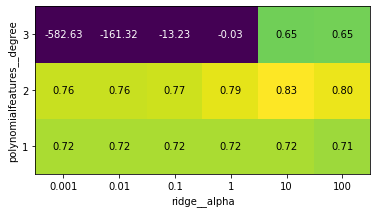

In [46]:
mglearn.tools.heatmap(grid.cv_results_['mean_test_score'].reshape(3, -1),
                      xlabel='ridge__alpha', ylabel='polynomialfeatures__degree',
                      xticklabels=param_grid['ridge__alpha'],
                      yticklabels=param_grid['polynomialfeatures__degree'],
                      vmin=0)

In [47]:
grid.best_params_

{'polynomialfeatures__degree': 2, 'ridge__alpha': 10}

In [49]:
print('test score: {:.2f}'.format(grid.score(X_test, y_test)))

test score: 0.77


In [53]:
# 다차항 특성이 없는 그리드 서치와 비교
param_grid = {'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
pipe = make_pipeline(StandardScaler(), Ridge())
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("다항 특성이 없을 때 점수: {:.2f}".format(grid.score(X_test, y_test)))

다항 특성이 없을 때 점수: 0.63


## 6.6 모델 선택을 위한 그리드 서치

In [54]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())])

In [56]:
from sklearn.ensemble import RandomForestClassifier

param_grid = [
    {'classifier': [SVC()], 'preprocessing': [StandardScaler()],
     'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
     'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'classifier': [RandomForestClassifier(n_estimators=100)],
     'preprocessing': [None], 'classifier__max_features': [1, 2, 3]}
]

In [57]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

In [59]:
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('preprocessing',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('classifier',
                                        SVC(C=1.0, cache_size=200,
                                            class_weight=None, coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='auto_deprecated',
                                            kernel='rbf', max_iter=-1,
                                            probability=False,
                                            random_state=Non...
                                                                min_impurity_decrease=0.0,

In [60]:
grid.best_params_

{'classifier': SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
     max_iter=-1, probability=False, random_state=None, shrinking=True,
     tol=0.001, verbose=False),
 'classifier__C': 10,
 'classifier__gamma': 0.01,
 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True)}

In [61]:
grid.best_score_

0.9859154929577465

In [62]:
grid.score(X_test, y_test)

0.9790209790209791

In [63]:
# 중복 계산 피하기. memory 매개변수를 사용해  계산 결과 캐싱

pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())], memory='cache_folder')